In [1]:
import numpy as np
import pandas as pd
from math import sqrt

import pickle
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## for machine learning

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Masking

In [2]:
file_path = "combined_eq_california" + "_timeseries" + ".csv"

df_eq = pd.read_csv(file_path)

df_eq = df_eq[["time", "mag", "sig", "longitude", "latitude", "depth"]]

df_eq["time"] = pd.to_datetime(df_eq["time"])
df_eq["timestamps"] = df_eq["time"]
#df_eq.set_index('time', inplace=True)


df_eq

,time,mag,sig,longitude,latitude,depth,timestamps
0,1970-01-02 10:45:20.570,3.14,152,-119.695667,34.206000,6.000000,1970-01-02 10:45:20.570
1,1970-01-02 21:47:53.740,2.61,105,-117.733667,35.735167,1.650000,1970-01-02 21:47:53.740
2,1970-01-03 02:51:58.400,4.00,246,-122.088000,37.298000,6.274206,1970-01-03 02:51:58.400
3,1970-01-03 19:48:40.840,3.16,154,-116.830500,33.960500,6.000000,1970-01-03 19:48:40.840
4,1970-01-04 02:27:15.700,2.74,116,-116.843333,34.333500,6.000000,1970-01-04 02:27:15.700
...,...,...,...,...,...,...,...
313327,2020-10-01 15:00:48.340,3.05,143,-115.572998,33.069332,13.970000,2020-10-01 15:00:48.340
313328,2020-10-01 15:10:23.760,2.05,65,-115.571000,33.080167,1.110000,2020-10-01 15:10:23.760
313329,2020-10-01 15:12:42.120,2.12,69,-115.578167,33.068000,2.650000,2020-10-01 15:12:42.120
313330,2020-10-01 15:21:41.480,3.02,140,-115.571999,33.079666,3.290000,2020-10-01 15:21:41.480


In [3]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313332 entries, 0 to 313331
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        313332 non-null  datetime64[ns]
 1   mag         313332 non-null  float64       
 2   sig         313332 non-null  int64         
 3   longitude   313332 non-null  float64       
 4   latitude    313332 non-null  float64       
 5   depth       313332 non-null  float64       
 6   timestamps  313332 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 16.7 MB


In [4]:
df_eq[df_eq.duplicated('timestamps')]

,time,mag,sig,longitude,latitude,depth,timestamps


In [5]:
# Dropping rows
df_eq = df_eq.drop_duplicates(subset=['timestamps'])

df_eq["timestamps"].diff().describe()

count                       313331
mean     0 days 01:25:11.019876935
std      0 days 02:33:43.027017800
min         0 days 00:00:00.009000
25%         0 days 00:08:25.260000
50%         0 days 00:36:55.740000
75%         0 days 01:45:43.790000
max         8 days 04:01:06.380000
Name: timestamps, dtype: object

In [6]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313332 entries, 0 to 313331
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        313332 non-null  datetime64[ns]
 1   mag         313332 non-null  float64       
 2   sig         313332 non-null  int64         
 3   longitude   313332 non-null  float64       
 4   latitude    313332 non-null  float64       
 5   depth       313332 non-null  float64       
 6   timestamps  313332 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 19.1 MB


In [7]:

df_eq["time_diff"] = df_eq["timestamps"].diff()

df_eq["time_diff_float"] = df_eq["time_diff"].apply(lambda x: x.total_seconds())



df_eq["mag_roll_10"] = df_eq["mag"].rolling(window=10).mean()

df_eq.dropna(inplace = True)

In [8]:
df_eq.describe().T

,count,mean,std,min,25%,50%,75%,max
mag,313323,2.50313,0.510172,2,2.14,2.35,2.7,7.3
sig,313323,101.847,56.3927,62,70,85,112,2910
longitude,313323,-118.583,3.33437,-131.771,-121.236,-118.096,-116.32,-107.001
latitude,313323,37.0011,4.0049,24.007,34.052,36.1962,38.8195,50
depth,313323,6.27424,6.20748,-3.5,2.232,5.385,8.777,257
time_diff,313323,0 days 01:25:09.914685356,0 days 02:33:38.876407841,0 days 00:00:00.009000,0 days 00:08:25.235000,0 days 00:36:55.720000,0 days 01:45:43.478000,8 days 04:01:06.380000
time_diff_float,313323,5109.91,9218.88,0.009,505.235,2215.72,6343.48,705666
mag_roll_10,313323,2.50314,0.226073,2.043,2.354,2.46,2.597,4.826


In [9]:
df_eq[df_eq["time_diff_float"] > 86400].shape

(608, 10)

In [10]:
df_eq[df_eq["time_diff_float"] > 86400]

,time,mag,sig,longitude,latitude,depth,timestamps,time_diff,time_diff_float,mag_roll_10
18,1970-01-11 13:50:41.420,2.24,77,-118.420167,35.492500,6.00,1970-01-11 13:50:41.420,1 days 02:05:15.740000,93915.74,2.841
37,1970-01-18 00:01:09.770,2.37,86,-117.290500,34.284167,5.81,1970-01-18 00:01:09.770,1 days 09:10:07.190000,119407.19,2.838
38,1970-01-19 07:16:25.380,4.49,310,-115.982000,31.882333,6.00,1970-01-19 07:16:25.380,1 days 07:15:15.610000,112515.61,3.007
42,1970-01-21 11:23:52.610,4.02,249,-115.978833,32.319667,6.00,1970-01-21 11:23:52.610,1 days 00:59:55.410000,89995.41,2.980
44,1970-01-23 16:30:01.120,3.97,242,-116.036833,37.137333,0.30,1970-01-23 16:30:01.120,1 days 13:37:46.280000,135466.28,3.060
...,...,...,...,...,...,...,...,...,...,...
303252,2019-09-02 01:53:55.010,2.41,89,-115.858667,33.902833,2.17,2019-09-02 01:53:55.010,1 days 03:59:44.940000,100784.94,2.321
305041,2020-01-02 00:42:09.750,2.27,79,-118.933500,37.638000,6.18,2020-01-02 00:42:09.750,1 days 02:23:48.590000,95028.59,2.269
305681,2020-03-02 00:31:07.620,2.43,91,-122.212333,40.926667,9.55,2020-03-02 00:31:07.620,1 days 02:11:00.190000,94260.19,2.484
309776,2020-06-02 00:30:49.240,2.01,62,-115.650500,33.154000,3.37,2020-06-02 00:30:49.240,1 days 01:25:13.490000,91513.49,2.450


In [11]:
min_date = df_eq["time"].min().date()

min_date

datetime.date(1970, 1, 7)

In [12]:
max_date = df_eq["time"].max().date()

max_date

datetime.date(2020, 10, 1)

In [13]:
type(df_eq["time"].max().date())

datetime.date

In [14]:
start_date = min_date

number_of_days = (max_date - min_date).days
print("number_of_days", number_of_days)
date_list = []
for day in range(number_of_days):
  a_date = (start_date + datetime.timedelta(days = day))
  date_list.append(a_date)

print(date_list[1], type(date_list[0]))

number_of_days 18530
1970-01-08 <class 'datetime.date'>


In [15]:
df_eq

,time,mag,sig,longitude,latitude,depth,timestamps,time_diff,time_diff_float,mag_roll_10
9,1970-01-07 01:14:49.890,3.31,169,-115.817667,31.591833,6.00,1970-01-07 01:14:49.890,0 days 02:56:39.220000,10599.22,3.263
10,1970-01-07 03:25:26.110,2.40,89,-117.651833,35.817500,5.66,1970-01-07 03:25:26.110,0 days 02:10:36.220000,7836.22,3.189
11,1970-01-07 18:04:50.000,3.07,145,-120.980667,34.607000,6.00,1970-01-07 18:04:50.000,0 days 14:39:23.890000,52763.89,3.235
12,1970-01-08 02:16:41.350,2.75,116,-117.139833,34.307833,6.00,1970-01-08 02:16:41.350,0 days 08:11:51.350000,29511.35,3.110
13,1970-01-08 17:00:33.860,3.70,211,-121.565833,34.574333,6.00,1970-01-08 17:00:33.860,0 days 14:43:52.510000,53032.51,3.164
...,...,...,...,...,...,...,...,...,...,...
313327,2020-10-01 15:00:48.340,3.05,143,-115.572998,33.069332,13.97,2020-10-01 15:00:48.340,0 days 00:11:30.200000,690.20,2.536
313328,2020-10-01 15:10:23.760,2.05,65,-115.571000,33.080167,1.11,2020-10-01 15:10:23.760,0 days 00:09:35.420000,575.42,2.540
313329,2020-10-01 15:12:42.120,2.12,69,-115.578167,33.068000,2.65,2020-10-01 15:12:42.120,0 days 00:02:18.360000,138.36,2.437
313330,2020-10-01 15:21:41.480,3.02,140,-115.571999,33.079666,3.29,2020-10-01 15:21:41.480,0 days 00:08:59.360000,539.36,2.488


In [16]:
df_eq.set_index('time', inplace=True)

In [17]:
df_daily = pd.DataFrame() 

df_daily['mag_max'] = df_eq.mag.resample('D').max() 
df_daily['event_count'] = df_eq.mag.resample('D').count() 
df_daily['mag_mean'] = df_eq.mag.resample('D').mean() 
df_daily['mag_sum'] = df_eq.mag.resample('D').sum() 
df_daily['mag_scatter'] = (df_eq.mag.resample('D').std()) 
df_daily["mag_roll_10"] = df_daily["mag_mean"].rolling(window=10).mean()


df_daily['longitude_mean'] = df_eq.longitude.resample('D').mean() 
df_daily['longitude_std'] = df_eq.longitude.resample('D').std() 

df_daily['latitude_mean'] = df_eq.latitude.resample('D').mean() 
df_daily['latitude_std'] = df_eq.latitude.resample('D').std() 

df_daily['depth_mean'] = df_eq.depth.resample('D').mean() 
df_daily['depth_std'] = df_eq.depth.resample('D').std() 

df_daily['time_diff_float_mean'] = df_eq.time_diff_float.resample('D').mean() 
df_daily['time_diff_float_std'] = df_eq.time_diff_float.resample('D').std() 


df_daily

,mag_max,event_count,mag_mean,mag_sum,mag_scatter,mag_roll_10,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std
time,,,,,,,,,,,,,,
1970-01-07,3.31,3,2.926667,8.78,0.471628,NaN,-118.150056,2.617310,34.005444,2.176113,5.886667,0.196299,23733.110000,25179.320539
1970-01-08,3.70,2,3.225000,6.45,0.671751,NaN,-119.352833,3.129655,34.441083,0.188444,6.000000,0.000000,41271.930000,16631.971737
1970-01-09,2.44,1,2.440000,2.44,NaN,NaN,-118.610167,NaN,35.397000,NaN,6.000000,NaN,43656.790000,NaN
1970-01-10,3.03,3,2.833333,8.50,0.290230,NaN,-117.889444,1.413732,38.679556,7.140646,4.788667,2.893839,36745.010000,33802.932830
1970-01-11,3.37,6,2.566667,15.40,0.564151,NaN,-119.576389,1.766064,35.231611,0.419287,5.928333,0.404496,19058.731667,37098.376200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,3.42,14,2.392143,33.49,0.439496,2.489418,-119.060979,4.298599,38.303695,3.580978,8.080714,4.231184,6060.481429,6451.768616
2020-09-28,3.48,14,2.337857,32.73,0.407340,2.471204,-118.630746,3.433816,39.499198,4.203920,8.485000,4.886213,5124.687857,4553.110763
2020-09-29,3.90,22,2.612273,57.47,0.494579,2.491639,-119.529770,3.722405,39.009423,3.155192,9.105909,6.797394,4278.077273,5654.603630


In [18]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18531 entries, 1970-01-07 to 2020-10-01
Freq: D
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mag_max               18094 non-null  float64
 1   event_count           18531 non-null  int64  
 2   mag_mean              18094 non-null  float64
 3   mag_sum               18531 non-null  float64
 4   mag_scatter           17707 non-null  float64
 5   mag_roll_10           15494 non-null  float64
 6   longitude_mean        18094 non-null  float64
 7   longitude_std         17707 non-null  float64
 8   latitude_mean         18094 non-null  float64
 9   latitude_std          17707 non-null  float64
 10  depth_mean            18094 non-null  float64
 11  depth_std             17707 non-null  float64
 12  time_diff_float_mean  18094 non-null  float64
 13  time_diff_float_std   17707 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 2.1 MB

<AxesSubplot:ylabel='time'>

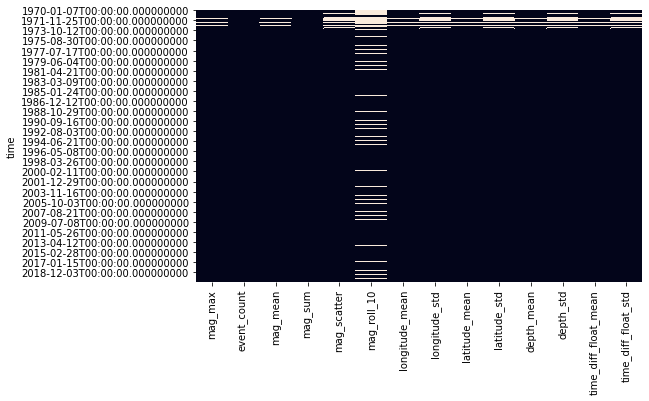

In [19]:
plt.figure(figsize = (8, 5))

sns.heatmap(df_daily.isnull(), cbar=False)

In [20]:
df_daily_clean = df_daily[df_daily.index > "1972-01-01"]

df_daily_clean.drop(columns = ["mag_roll_10"], inplace = True)

df_daily_clean

C:\ProgramData\Anaconda2021\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,mag_max,event_count,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std
time,,,,,,,,,,,,,
1972-01-02,2.90,2,2.500000,5.00,0.565685,-119.561583,4.108880,40.894750,9.463092,13.193500,10.173145,64877.640000,90530.909480
1972-01-03,4.60,1,4.600000,4.60,NaN,-112.170000,NaN,38.650000,NaN,7.000000,NaN,105546.310000,NaN
1972-01-04,2.30,1,2.300000,2.30,NaN,-123.153333,NaN,47.200833,NaN,15.401000,NaN,81088.790000,NaN
1972-01-05,NaN,0,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1972-01-06,3.54,3,2.976667,8.93,0.525389,-118.016000,0.502106,34.827556,0.851343,1.980000,3.266298,66695.046667,73587.754649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,3.42,14,2.392143,33.49,0.439496,-119.060979,4.298599,38.303695,3.580978,8.080714,4.231184,6060.481429,6451.768616
2020-09-28,3.48,14,2.337857,32.73,0.407340,-118.630746,3.433816,39.499198,4.203920,8.485000,4.886213,5124.687857,4553.110763
2020-09-29,3.90,22,2.612273,57.47,0.494579,-119.529770,3.722405,39.009423,3.155192,9.105909,6.797394,4278.077273,5654.603630


<AxesSubplot:ylabel='time'>

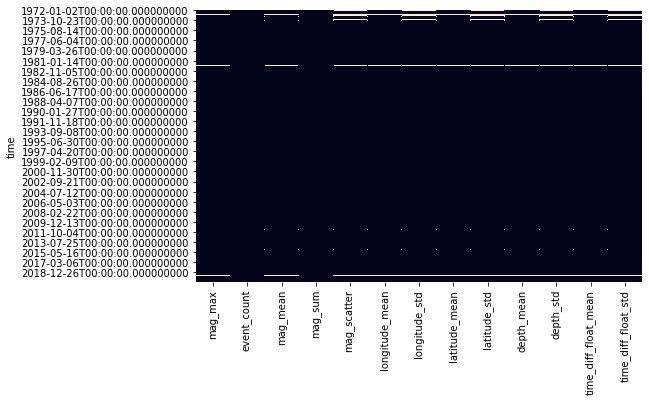

In [21]:
plt.figure(figsize = (8, 5))

sns.heatmap(df_daily_clean.isnull(), cbar=False)

In [22]:
df_daily_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17806 entries, 1972-01-02 to 2020-10-01
Freq: D
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mag_max               17498 non-null  float64
 1   event_count           17806 non-null  int64  
 2   mag_mean              17498 non-null  float64
 3   mag_sum               17806 non-null  float64
 4   mag_scatter           17308 non-null  float64
 5   longitude_mean        17498 non-null  float64
 6   longitude_std         17308 non-null  float64
 7   latitude_mean         17498 non-null  float64
 8   latitude_std          17308 non-null  float64
 9   depth_mean            17498 non-null  float64
 10  depth_std             17308 non-null  float64
 11  time_diff_float_mean  17498 non-null  float64
 12  time_diff_float_std   17308 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.9 MB


In [23]:
df_daily_clean.interpolate('time', inplace = True)
df_daily_clean

<ipython-input-23-7fcade35294c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_daily_clean.interpolate('time', inplace = True)


,mag_max,event_count,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std
time,,,,,,,,,,,,,
1972-01-02,2.90,2,2.500000,5.00,0.565685,-119.561583,4.108880,40.894750,9.463092,13.193500,10.173145,64877.640000,90530.909480
1972-01-03,4.60,1,4.600000,4.60,0.555611,-112.170000,3.207186,38.650000,7.310155,7.000000,8.446433,105546.310000,86295.120772
1972-01-04,2.30,1,2.300000,2.30,0.545537,-123.153333,2.305493,47.200833,5.157218,15.401000,6.719721,81088.790000,82059.332064
1972-01-05,2.92,0,2.638333,0.00,0.535463,-120.584667,1.403799,41.014194,3.004280,8.690500,4.993010,73891.918333,77823.543356
1972-01-06,3.54,3,2.976667,8.93,0.525389,-118.016000,0.502106,34.827556,0.851343,1.980000,3.266298,66695.046667,73587.754649
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-27,3.42,14,2.392143,33.49,0.439496,-119.060979,4.298599,38.303695,3.580978,8.080714,4.231184,6060.481429,6451.768616
2020-09-28,3.48,14,2.337857,32.73,0.407340,-118.630746,3.433816,39.499198,4.203920,8.485000,4.886213,5124.687857,4553.110763
2020-09-29,3.90,22,2.612273,57.47,0.494579,-119.529770,3.722405,39.009423,3.155192,9.105909,6.797394,4278.077273,5654.603630


In [24]:
df_daily_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17806 entries, 1972-01-02 to 2020-10-01
Freq: D
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mag_max               17806 non-null  float64
 1   event_count           17806 non-null  int64  
 2   mag_mean              17806 non-null  float64
 3   mag_sum               17806 non-null  float64
 4   mag_scatter           17806 non-null  float64
 5   longitude_mean        17806 non-null  float64
 6   longitude_std         17806 non-null  float64
 7   latitude_mean         17806 non-null  float64
 8   latitude_std          17806 non-null  float64
 9   depth_mean            17806 non-null  float64
 10  depth_std             17806 non-null  float64
 11  time_diff_float_mean  17806 non-null  float64
 12  time_diff_float_std   17806 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.9 MB


In [25]:
df_eq = df_daily_clean
df_eq.shape

(17806, 13)

In [26]:
## Large earthquakes labeling:
label = []
cnt = 0
for i, mag in enumerate(df_eq["mag_max"]):
    if (mag>5.5):
        cnt = cnt + 1
        label.append(int(cnt))
    else:
        label.append(0)

df_eq["large_eq_label"] = label

<ipython-input-26-5c874ae64211>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eq["large_eq_label"] = label


In [27]:
df_eq.describe().T

,count,mean,std,min,25%,50%,75%,max
mag_max,17806.0,3.531407,0.703016,2.000000,3.010000,3.400000,3.920000,7.300000
event_count,17806.0,17.500955,30.741280,0.000000,9.000000,13.000000,19.000000,1800.000000
mag_mean,17806.0,2.498802,0.215661,2.000000,2.368457,2.460445,2.576364,5.800000
mag_sum,17806.0,43.760240,81.277989,0.000000,22.770000,32.810000,46.187500,5075.860000
mag_scatter,17806.0,0.449793,0.196728,0.000000,0.316971,0.413549,0.544998,1.994041
longitude_mean,17806.0,-118.902148,1.504638,-127.923500,-119.875837,-118.906986,-117.957002,-108.287050
longitude_std,17806.0,3.148797,1.048462,0.001532,2.480551,3.099534,3.781318,11.074117
latitude_mean,17806.0,37.382431,2.019502,27.540000,36.090607,37.186525,38.466116,49.071000
latitude_std,17806.0,3.661762,1.397388,0.001532,2.668346,3.647200,4.566034,16.128139
depth_mean,17806.0,6.757191,2.791850,-1.115000,5.041752,6.391071,8.067750,48.270000


In [28]:
df_eq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17806 entries, 1972-01-02 to 2020-10-01
Freq: D
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   mag_max               17806 non-null  float64
 1   event_count           17806 non-null  int64  
 2   mag_mean              17806 non-null  float64
 3   mag_sum               17806 non-null  float64
 4   mag_scatter           17806 non-null  float64
 5   longitude_mean        17806 non-null  float64
 6   longitude_std         17806 non-null  float64
 7   latitude_mean         17806 non-null  float64
 8   latitude_std          17806 non-null  float64
 9   depth_mean            17806 non-null  float64
 10  depth_std             17806 non-null  float64
 11  time_diff_float_mean  17806 non-null  float64
 12  time_diff_float_std   17806 non-null  float64
 13  large_eq_label        17806 non-null  int64  
dtypes: float64(12), int64(2)
memory usage: 2.0 MB

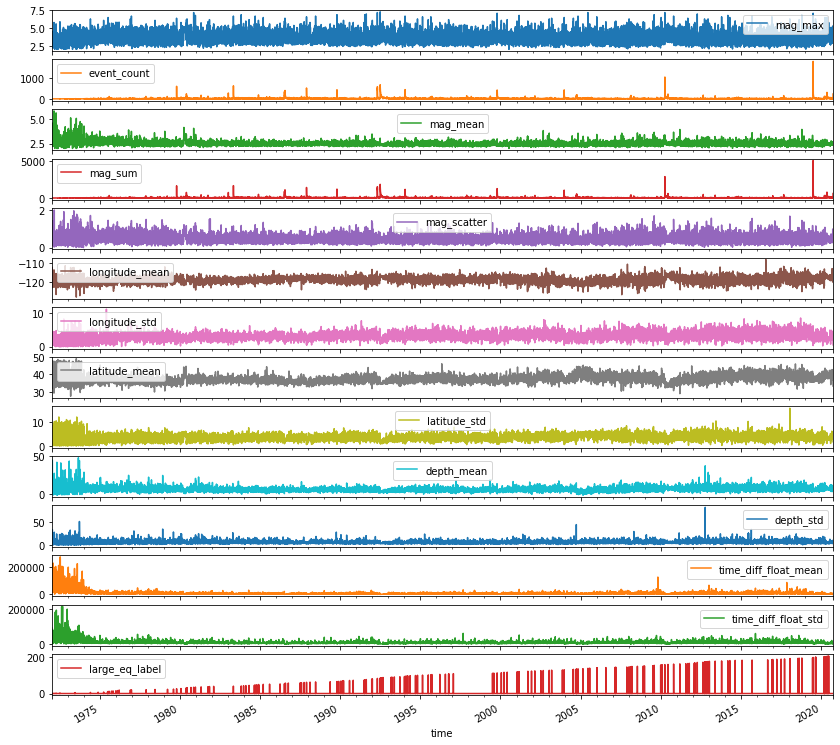

In [29]:
df_eq.plot(subplots=True,figsize=(14,14));

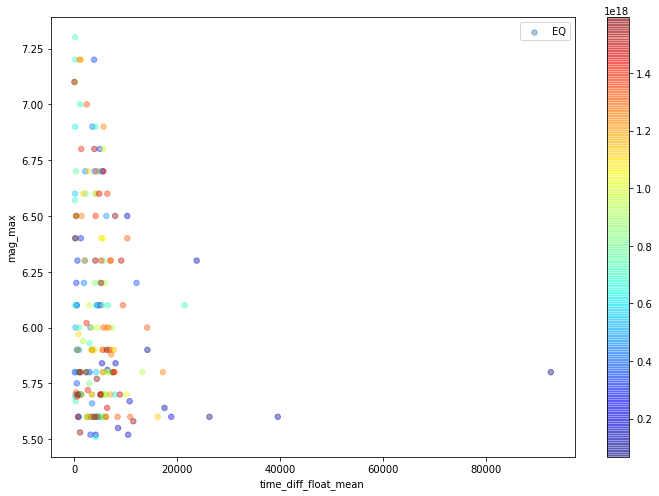

In [30]:
large_eq = df_eq[df_eq["large_eq_label"]>0]

ax = plt.gca()


large_eq.plot(kind="scatter", x="time_diff_float_mean", y="mag_max",
    s=30, label="EQ",
    c=large_eq.index, cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.4, figsize=(10,7), ax = ax
)
plt.legend()

plt.tight_layout()

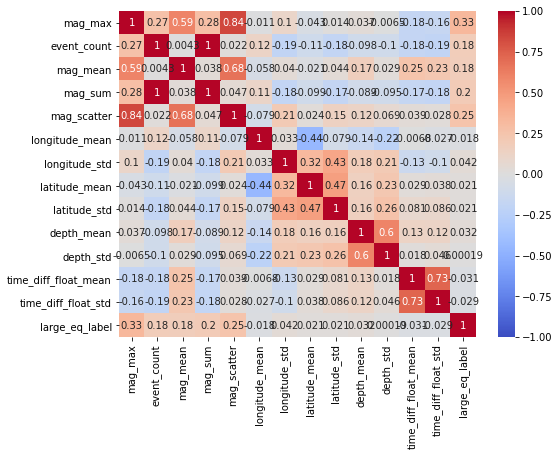

In [31]:
df_corr = df_eq.corr()

plt.figure(figsize=(8,6))
sns.heatmap(df_corr,
        vmin=-1,
        cmap='coolwarm',
        annot=True);

In [32]:
df_eq.head(1)

,mag_max,event_count,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std,large_eq_label
time,,,,,,,,,,,,,,
1972-01-02,2.9,2,2.5,5.0,0.565685,-119.561583,4.10888,40.89475,9.463092,13.1935,10.173145,64877.64,90530.90948,0


Text(0, 0.5, 'Latitude')

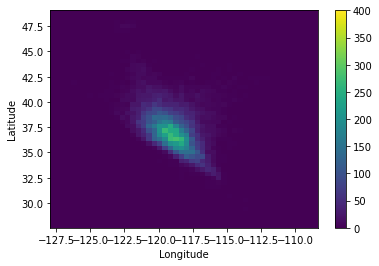

In [33]:
df_eq_plot = df_eq[df_eq["depth_mean"]<50]

plt.hist2d(df_eq_plot['longitude_mean'], df_eq_plot['latitude_mean'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Longitude')
plt.ylabel('Latitude')

Text(0, 0.5, 'Depth (km)')

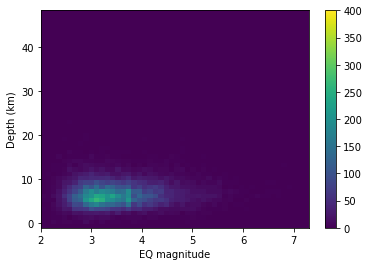

In [34]:
df_eq_plot = df_eq[df_eq["depth_mean"]<50]

plt.hist2d(df_eq_plot['mag_max'], df_eq_plot['depth_mean'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('EQ magnitude')
plt.ylabel('Depth (km)')

In [35]:
df_eq["time_diff_float_mean"].describe()

count     17806.000000
mean       9281.527799
std       13972.154563
min          47.986567
25%        4644.754700
50%        6506.137750
75%        9291.286319
max      272242.960000
Name: time_diff_float_mean, dtype: float64

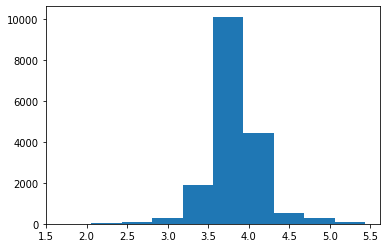

In [36]:
plt.hist(np.log10(df_eq["time_diff_float_mean"]));

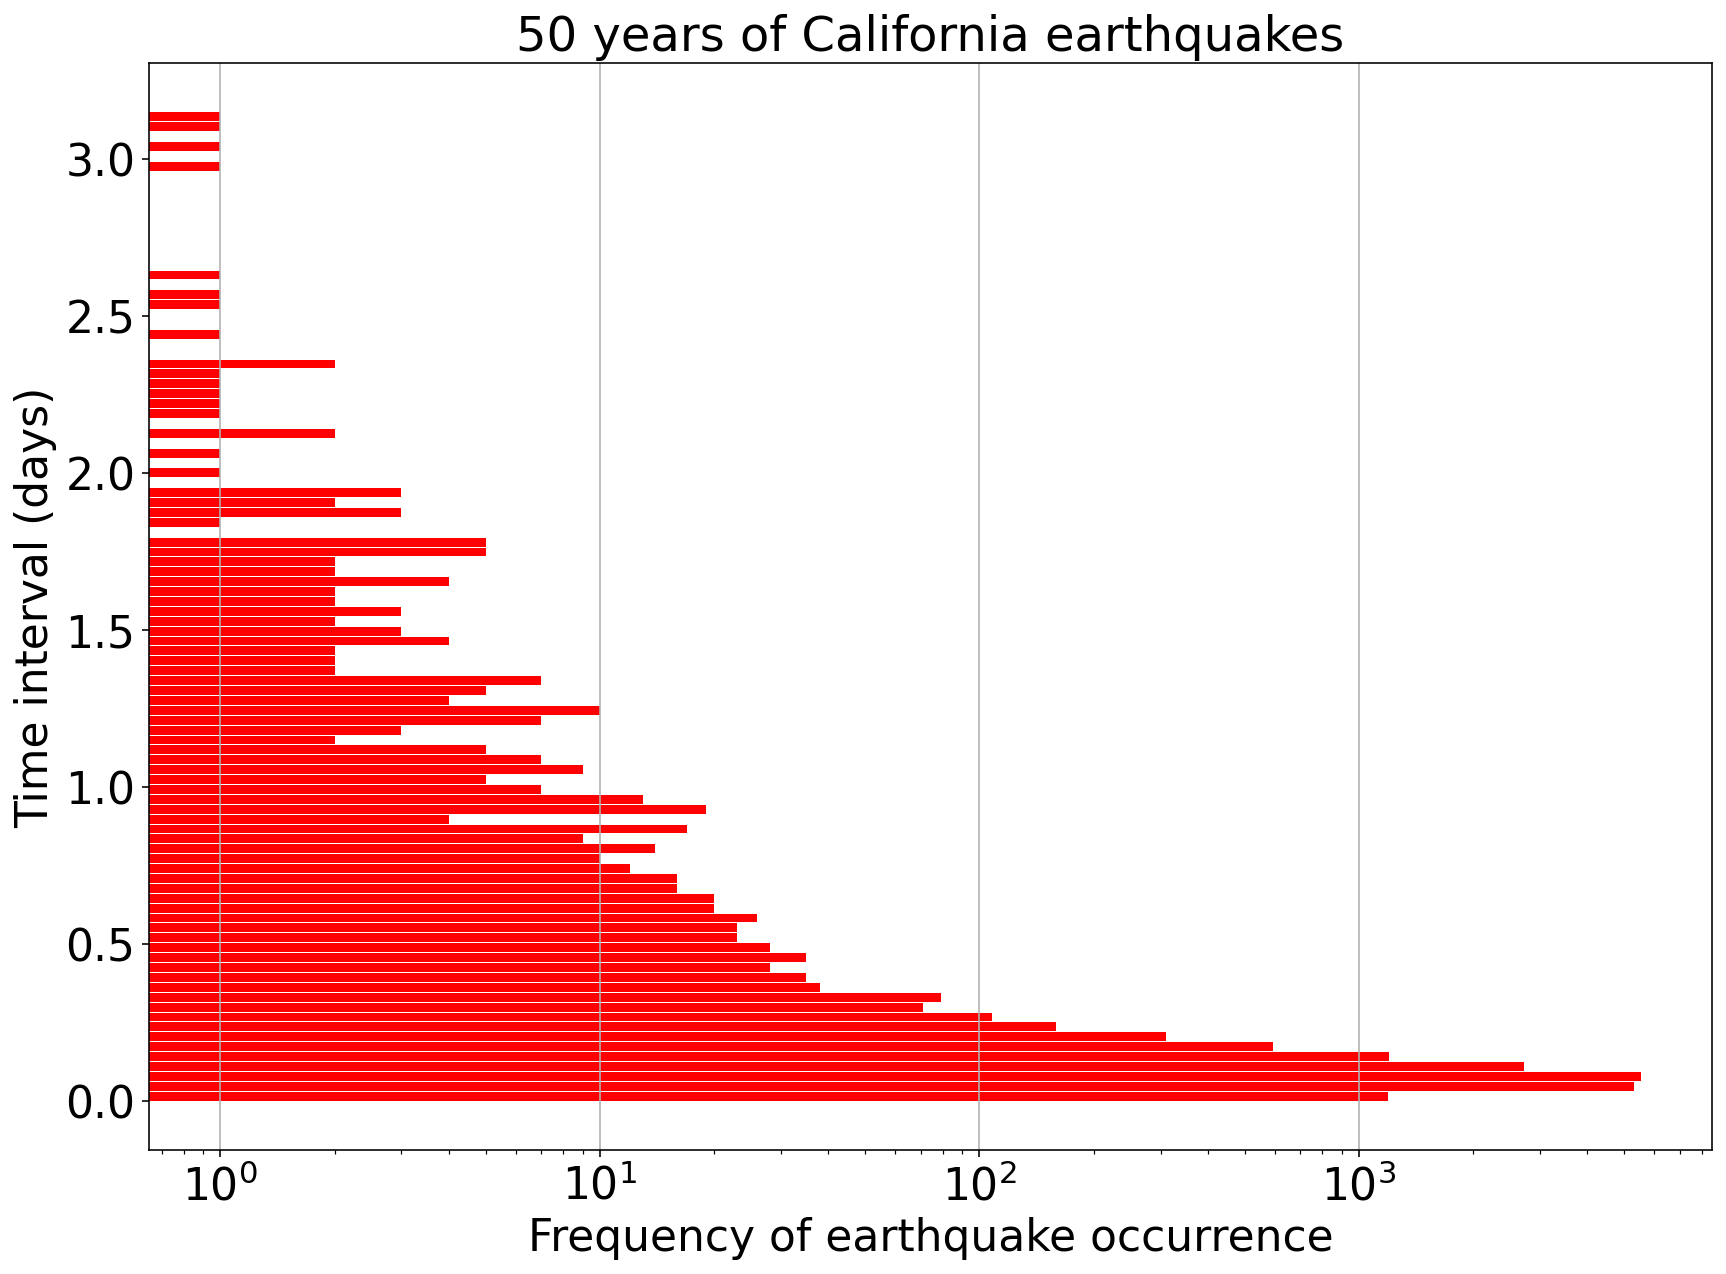

In [37]:
df_eq_plot = df_eq.copy()
df_eq_plot["time_days"] = (np.array(df_eq_plot["time_diff_float_mean"])/86_400)


%config InlineBackend.figure_format = 'retina'
plt.figure(figsize = (14, 10));

df_eq_plot["time_days"].plot.hist(grid=True, bins=100, rwidth=0.9,orientation="horizontal",
                   color='red')

plt.title('50 years of California earthquakes',fontsize = 24)
plt.ylabel('Time interval (days)',fontsize = 22)
plt.xlabel('Frequency of earthquake occurrence',fontsize = 22)

plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)

plt.grid(axis='y', alpha=0.75)

plt.xscale('log')


In [38]:
df_eq.head(2)

,mag_max,event_count,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std,large_eq_label
time,,,,,,,,,,,,,,
1972-01-02,2.9,2,2.5,5.0,0.565685,-119.561583,4.108880,40.89475,9.463092,13.1935,10.173145,64877.64,90530.909480,0
1972-01-03,4.6,1,4.6,4.6,0.555611,-112.170000,3.207186,38.65000,7.310155,7.0000,8.446433,105546.31,86295.120772,0


In [39]:
df_eq_model = df_eq.drop(columns = ["large_eq_label"])

train_size = int(len(df_eq_model)* 0.9)
test_size = len(df_eq_model) - train_size
train, test = df_eq_model.iloc[0:train_size], df_eq_model.iloc[train_size:len(df_eq_model)]

print(train.shape, test.shape)

(16025, 13) (1781, 13)


In [40]:
train.head(2)

,mag_max,event_count,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std
time,,,,,,,,,,,,,
1972-01-02,2.9,2,2.5,5.0,0.565685,-119.561583,4.108880,40.89475,9.463092,13.1935,10.173145,64877.64,90530.909480
1972-01-03,4.6,1,4.6,4.6,0.555611,-112.170000,3.207186,38.65000,7.310155,7.0000,8.446433,105546.31,86295.120772


In [41]:
test.head(2)

,mag_max,event_count,mag_mean,mag_sum,mag_scatter,longitude_mean,longitude_std,latitude_mean,latitude_std,depth_mean,depth_std,time_diff_float_mean,time_diff_float_std
time,,,,,,,,,,,,,
2015-11-17,2.79,12,2.366667,28.40,0.238874,-118.510814,4.431423,38.609539,3.788335,9.164167,7.158176,7044.566833,7393.333314
2015-11-18,3.39,13,2.583077,33.58,0.466751,-119.214556,4.975327,39.655182,4.490104,5.844615,5.725807,6791.768462,6488.976717


Scaling the data:

In [42]:
f_columns = ['event_count', 'mag_mean', 'mag_sum', 'mag_scatter',
       'longitude_mean', 'longitude_std', 'latitude_mean', 'latitude_std',
       'depth_mean', 'depth_std', 'time_diff_float_mean',
       'time_diff_float_std']

f_transformer = RobustScaler()
mag_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
mag_transformer = mag_transformer.fit(train[["mag_max"]])

In [43]:
f_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'unit_variance': False,
 'with_centering': True,
 'with_scaling': True}

In [44]:
train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train["mag_max"] = mag_transformer.transform(train[["mag_max"]])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test["mag_max"] = mag_transformer.transform(test[["mag_max"]])

C:\ProgramData\Anaconda2021\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
<ipython-input-44-70270e94569e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["mag_max"] = mag_transformer.transform(train[["mag_max"]])
C:\ProgramData\Anaconda2021\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [45]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)- time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)


In [46]:
TIME_STEPS = 120

X_train, y_train = create_dataset(train, train["mag_max"], time_steps = TIME_STEPS)

X_test, y_test = create_dataset(test, test["mag_max"], time_steps= TIME_STEPS)

In [47]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)



(15905, 120, 13) (15905,)
(1661, 120, 13) (1661,)


In [48]:
X_train[0][0]

array([-0.54347826, -1.2       ,  0.17927171, -1.21382843,  0.65599052,
       -0.32054318,  0.83437991,  1.68890137,  3.09877253,  2.36600955,
        1.62158181, 12.99730879, 17.91891303])

In [49]:
model = keras.Sequential()
# Adding bi-directional layer
model.add(keras.layers.LSTM(units=128, input_shape = (X_train.shape[1], X_train.shape[2]),
                                   return_sequences = True))
model.add(keras.layers.LeakyReLU(alpha = 0.5))
model.add(keras.layers.LSTM(units=128,
                                   return_sequences = True))
model.add(keras.layers.LeakyReLU(alpha = 0.5))
# Adding dropout layer to regularize complexities 
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.LSTM(units=64,
                                   return_sequences = False))
model.add(keras.layers.Dropout(rate = 0.3))
model.add(keras.layers.Dense(units = 1))

In [50]:

model = keras.Sequential()
# Adding bi-directional layer
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=32,
            input_shape = (X_train.shape[1], X_train.shape[2])
        )
    )
)
# Adding dropout layer to regularize complexities 
model.add(keras.layers.Dropout(rate = 0.7))

# Add output layer
model.add(keras.layers.Dense(units = 1))


In [51]:
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [52]:
history = model.fit(
    X_train, y_train,
    epochs = 5,
    batch_size = 32,
    validation_split = 0.2, 
    shuffle = False # As it is time-series
)

Epoch 1/5
398/398 [==============================] - 28s 55ms/step - loss: 0.9046 - val_loss: 0.5970
Epoch 2/5
398/398 [==============================] - 23s 58ms/step - loss: 0.6599 - val_loss: 0.5957
Epoch 3/5
398/398 [==============================] - 24s 61ms/step - loss: 0.6198 - val_loss: 0.5918
Epoch 4/5
398/398 [==============================] - 25s 62ms/step - loss: 0.5959 - val_loss: 0.5897
Epoch 5/5
398/398 [==============================] - 26s 66ms/step - loss: 0.5820 - val_loss: 0.5920


In [53]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 64)                11776     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 11,841
Trainable params: 11,841
Non-trainable params: 0
_________________________________________________________________


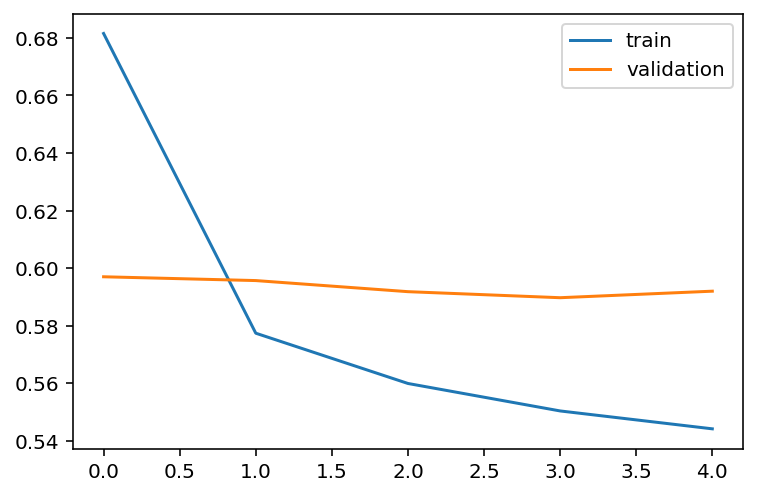

In [54]:
plt.plot(history.history["loss"], label = "train")
plt.plot(history.history["val_loss"], label = "validation")
plt.legend()


In [55]:
y_pred = model.predict(X_test)

In [56]:
y_train_inv = mag_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = mag_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = mag_transformer.inverse_transform(y_pred)





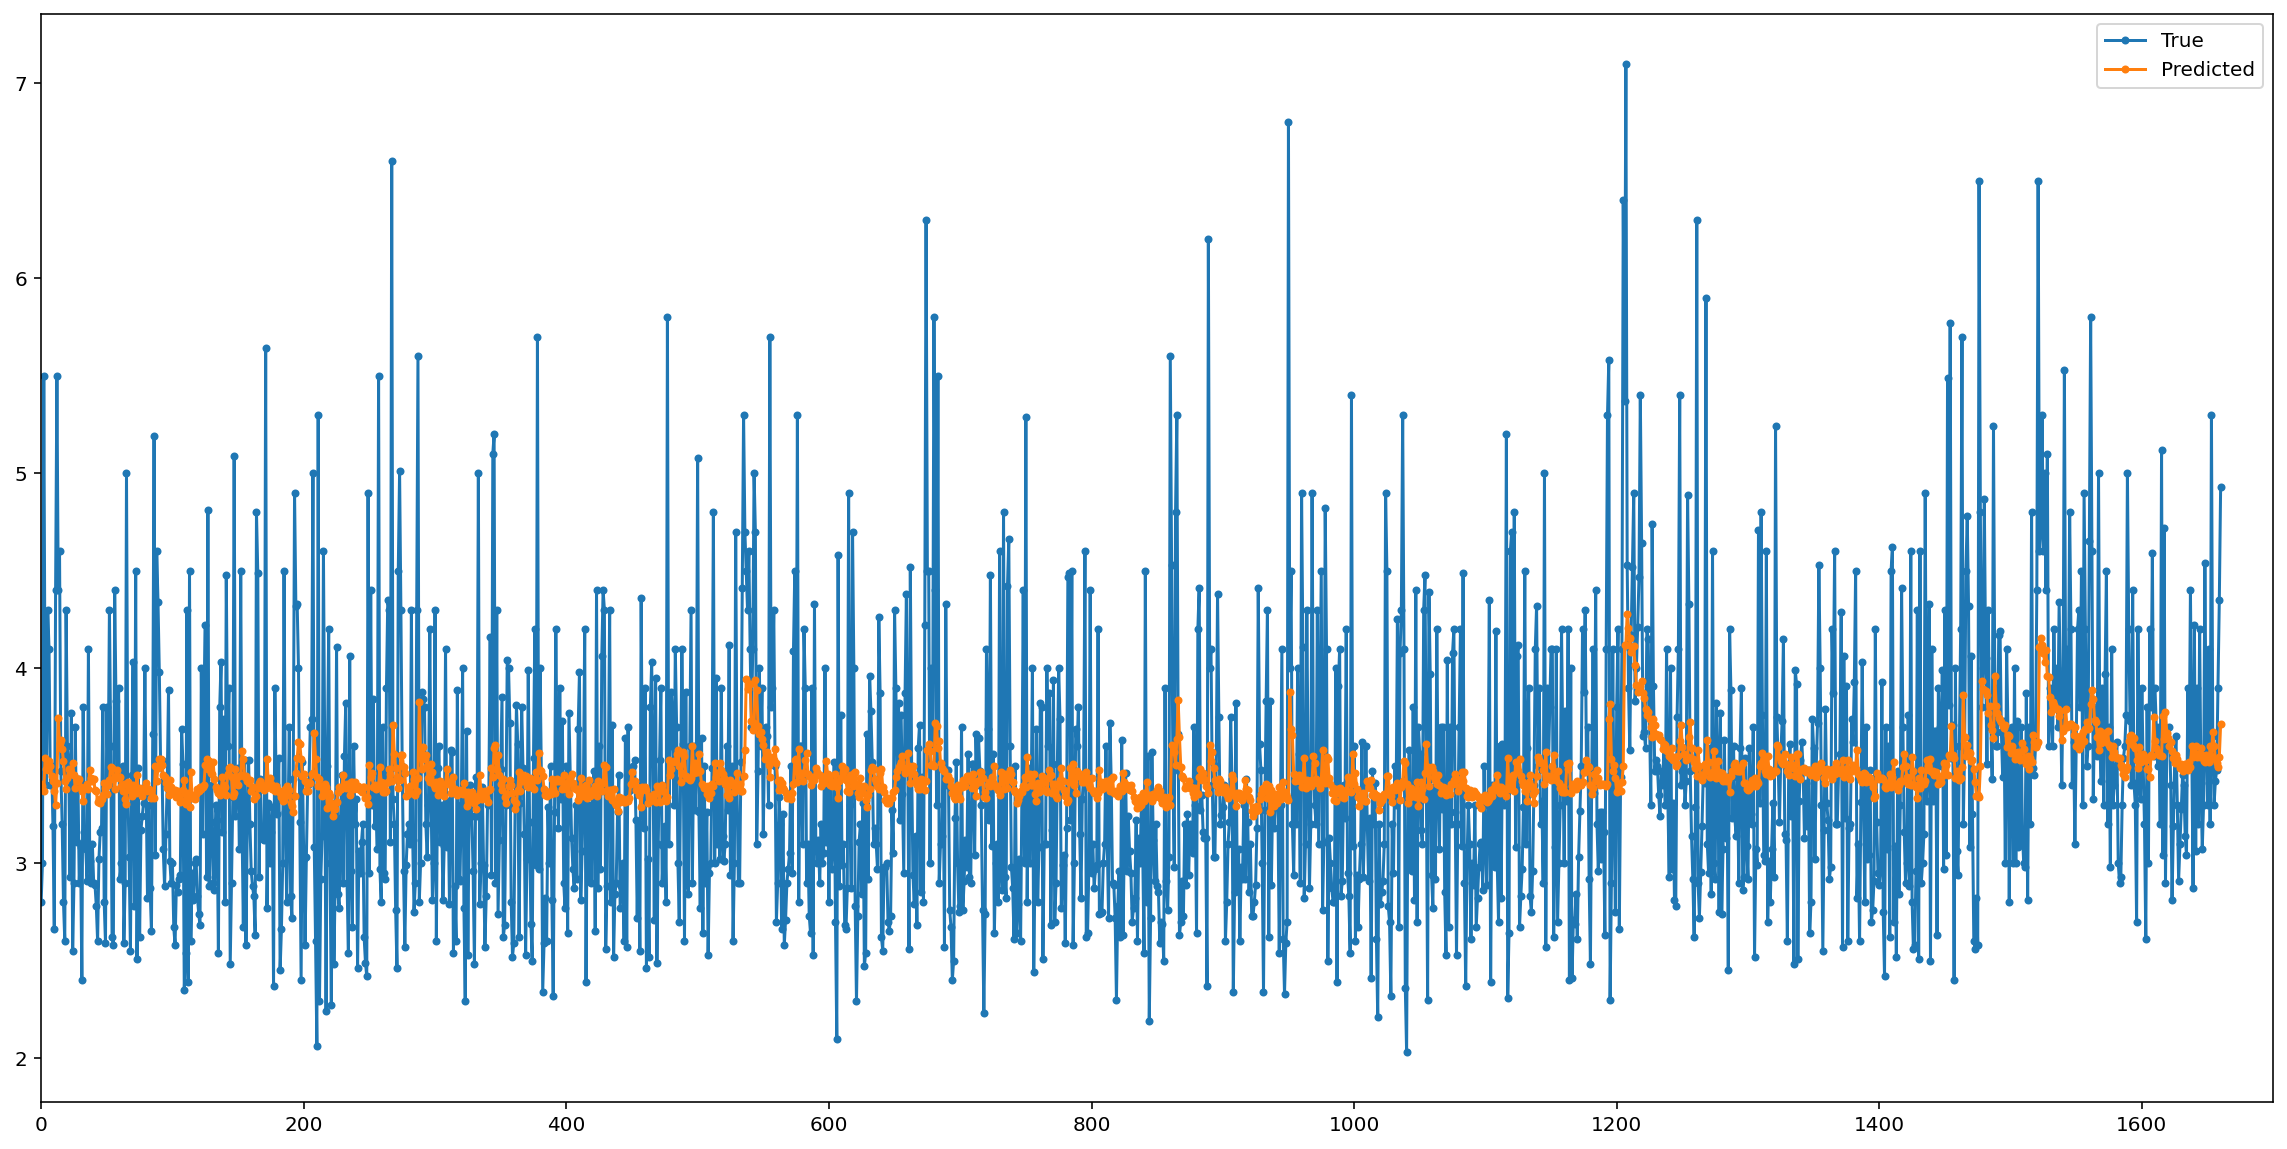

In [57]:
plt.figure(figsize = (20,10))
plt.plot(y_test_inv.flatten(), marker = '.', label = "True")
plt.plot(y_pred_inv.flatten(), marker = '.', label = "Predicted")
plt.xlim(0,1700)
plt.legend()